## Preprocessing and Data Preparation
Yudhistira Yoga Semeru (7046952)

In [27]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [28]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import necessary libraries and tune parameters

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from src.utils import utils
from src.methods import ExtrinsicMatrix
import cv2
import glob
import json

PROJECT_DIR = os.getcwd()

In [71]:
# Editable part
dataset_name = "milk_stage2"
min_length = 3  # minimum number of next images that should not be ignored
min_correspondences_limit = 300  # process a correspondences only if it exceeds 200 points

In [72]:
# info = utils.import_json(f"./dataset/{dataset_name}/info.json")
dataset_info = utils.get_dataset_info(dataset_name, PROJECT_DIR)
dataset_info["data"]


{'path': '/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/dataset/milk_stage2',
 'image': '/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/dataset/milk_stage2/images',
 'correspondence': '/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/dataset/milk_stage2/correspondences'}

## Step 0. Find unique 3D point label

In [73]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


class PointCorrespondenceManager:
    def __init__(self, dataset_info={}):
        self.point_idx = -1
        self.data = {}
        self.dataset_info = dataset_info
        self.num_img_max = -1
        self.max_point_age = 15
        self.same_points = {}
        self.points_age_counter = {}

    def _find_closest_point(self, frame_name, xy):
        if len(self.data[frame_name].keys()) == 0:
            return None
        differences = np.array(list(self.data[frame_name].values())) - np.array(xy)
        distances = np.linalg.norm(differences, axis=1)
        minimum_dist_idx = np.argmin(distances)
        minimum_dist = distances[minimum_dist_idx]
        if minimum_dist < 0.00001:
            return list(self.data[frame_name].keys())[minimum_dist_idx]
        else:
            return None

    def save(self):
        # save unique_points.json
        outfile = os.path.join(self.dataset_info["data"]["path"], "unique_points.json")
        with open(outfile, 'w', encoding='utf-8') as f:
            json.dump(self.data, f, cls=NpEncoder)
        
        # save same_points.json
        outfile = os.path.join(self.dataset_info["data"]["path"], "same_points.json")
        with open(outfile, 'w', encoding='utf-8') as f:
            json.dump(self.same_points, f, cls=NpEncoder)

    def load(self):
        self.data = utils.import_json(os.path.join(self.dataset_info["data"]["path"], "unique_points.json"))
        self.point_idx = len(self.data.keys())

    def set(self, frame_idx_l, frame_idx_r, xy_l, xy_r):
        """
            Set the frame indices and point position, 
            the class will automatically finds the closest point and assign an index.

            frame_idx_l (int)
            frame_idx_r (int)
            xy_l [float, float]
            xy_r [float, float]            
        """

        # check if image exist
        frame_name_img_l = "i{}".format(frame_idx_l)
        frame_name_img_r = "i{}".format(frame_idx_r)
        if frame_name_img_l not in self.data.keys():
            self.data[frame_name_img_l] = {}
        if frame_name_img_r not in self.data.keys():
            self.data[frame_name_img_r] = {}

        # check if the point already exist in the left image
        closest_point_l = self._find_closest_point(frame_name_img_l, xy_l)
        closest_point_r = self._find_closest_point(frame_name_img_r, xy_r)
        
        # if either one of them is already assigned a point, make it the same!
        if closest_point_l != None or closest_point_r != None:
            if closest_point_l != None and closest_point_r != None:
                if closest_point_l != closest_point_r:
                    # if already known, just add it to the same points dict
                    self.same_points[closest_point_l] = closest_point_r
                    self.same_points[closest_point_r] = closest_point_l
                else:
                    # if indices are the same, just skip it
                    pass
            elif closest_point_l != None:
                # if the left point exist but not the right point, transfer the point
                # if the point not yet exceeds the maximum point "age", simply increase counter
                if(self.points_age_counter[closest_point_l]) < self.max_point_age:
                    self.data[frame_name_img_r][closest_point_l] = list(xy_r)
                    self.points_age_counter[closest_point_l] += 1
                else:
                    # if it exceeds the counter, assign a new point index and 
                    # 
                    self.point_idx += 1
                    new_pt_name = f"p{self.point_idx}"
                    self.data[frame_name_img_r][new_pt_name] = list(xy_r)
                    self.points_age_counter[new_pt_name] = 1
                    self.same_points[closest_point_l] = new_pt_name
                    # self.same_points[new_pt_name] = closest_point_l

                # print(f"transfer right {closest_point_l}")
            elif closest_point_r != None:
                if(self.points_age_counter[closest_point_r]) < self.max_point_age:
                    self.data[frame_name_img_l][closest_point_r] = list(xy_r)
                    self.points_age_counter[closest_point_r] += 1
                else:
                    self.point_idx += 1
                    new_pt_name = f"p{self.point_idx}"
                    self.data[frame_name_img_l][new_pt_name] = list(xy_r)
                    self.points_age_counter[new_pt_name] = 1
                    self.same_points[closest_point_r] = new_pt_name
                    # self.same_points[new_pt_name] = closest_point_r
                
                # print(f"transfer left {closest_point_r}")
            else:
                print("unknown case hmmm")
        elif (closest_point_l == None and closest_point_r == None):
            # if both of them are None, assign new point
            self.point_idx += 1
            frame_name_pts = "p{}".format(self.point_idx)
            self.points_age_counter[frame_name_pts] = 2
            # frame_name_pts = "p{}".format(self.point_idx)
            self.data[frame_name_img_l][frame_name_pts] = list(xy_l)
            self.data[frame_name_img_r][frame_name_pts] = list(xy_r)
        else:
            print("special case! in which I have no idea how to solve")

        # self.point_idx += 1
        # frame_name_pts = "p{}".format(self.point_idx)
        # # frame_name_pts = "p{}".format(self.point_idx)
        # self.data[frame_name_img_l][frame_name_pts] = list(xy_l)
        # self.data[frame_name_img_r][frame_name_pts] = list(xy_r)

    def get_data(self):
        # get acquired data
        return self.data
    
    def get_correspondences(self):
        images_list = glob.glob(os.path.join(self.dataset_info["data"]["image"], "*jpg"))
        img_indexes = sorted([int(os.path.basename(i).split(".")[0]) for i in images_list])
        if self.num_img_max != -1:
            img_indexes = img_indexes[:self.num_img_max]
        corr_counts = np.zeros((len(img_indexes), len(img_indexes)))
        for i, i_l in enumerate(img_indexes):
            for j, i_r in enumerate(img_indexes):
                if i_l == i_r:
                    continue
                
                # check if there is correspondences
                if utils.is_correspondence_exist(PROJECT_DIR, dataset_name, i_l, i_r):
                    correspondences_path = os.path.join(self.dataset_info["data"]["correspondence"], f"{i_l}_{i_r}.txt")
                    corr_data = utils.read_txt(correspondences_path)
                    corr_counts[i, j] = len(corr_data)
                    corr_counts[j, i] = len(corr_data)
        
        return {
            "labels": img_indexes,
            "counts": corr_counts
        }
    
    def relabel(self, num_img_max=-1):
        img_idx = np.array([int(os.path.basename(i).split(".")[0]) for i in glob.glob(os.path.join(self.dataset_info["data"]["image"], "*.jpg"))])
        img_idx = sorted(img_idx)
        if num_img_max != -1:
            img_idx = img_idx[:num_img_max]
            self.num_img_max = num_img_max

        for i, i_l in enumerate(img_idx):
            for j, i_r in enumerate(img_idx):
                if i_l == i_r:
                    continue
                
                # check if there is correspondences
                if utils.is_correspondence_exist(PROJECT_DIR, "box", i_l, i_r):
                    correspondences_path = os.path.join(dataset_info["data"]["correspondence"], f"{i_l}_{i_r}.txt")
                    corr_data = utils.read_txt(correspondences_path)
                    for i, corr in enumerate(corr_data):
                        # p1_x, p1_y, p2_x, p2_y = np.array(corr.rstrip().split(" ")).astype(np.double).astype(int)
                        p1_x, p1_y, p2_x, p2_y = np.array(corr.rstrip().split(" ")).astype(float)
                        self.set(int(i_l), int(i_r), [p1_x, p1_y], [p2_x, p2_y])

    def reset(self):
        # reset stored data and free memory
        self.data = {}

point_manager = PointCorrespondenceManager(dataset_info)

### Utilize preprocessing step

In [74]:
img_idx = np.array([int(os.path.basename(i).split(".")[0]) for i in glob.glob(os.path.join(dataset_info["data"]["image"], "*.jpg"))])
img_idx = sorted(img_idx)

corr_counts = np.zeros((len(img_idx), len(img_idx)))
for i, img_name_l in enumerate(img_idx):
    for j, j_idx in enumerate(range(i+1, len(img_idx))):
        img_name_r = img_idx[j_idx]
        if img_name_l == img_name_r:
            continue
        
        corr_data = []
        # check if there is correspondences
        corr_l_exist, corr_r_exist, corr_exist = utils.is_correspondence_exist(PROJECT_DIR, dataset_name, img_name_l, img_name_r)
        if corr_exist:
            if corr_l_exist:
                correspondences_path = os.path.join(dataset_info["data"]["correspondence"], f'{img_name_l}_{img_name_r}.txt')
                corr_data = utils.read_txt(correspondences_path)
                if (j >= min_length):
                    if len(corr_data) < min_correspondences_limit:
                        # if (j != 0):
                        #     break
                        continue      
                    else:
                        pass       
                for k, corr in enumerate(corr_data):
                    p1_x, p1_y, p2_x, p2_y = np.array(corr.rstrip().split(" ")).astype(float)
                    point_manager.set(int(img_name_l), int(img_name_r), [p1_x, p1_y], [p2_x, p2_y])
                corr_counts[i, j_idx] = len(corr_data)
                corr_counts[j_idx, i] = len(corr_data)
                print(img_name_l, img_name_r, len(corr_data))
            elif corr_r_exist:
                correspondences_path = os.path.join(dataset_info["data"]["correspondence"], f'{img_name_r}_{img_name_l}.txt')
                # correspondences_path = f'/home/yudzyoga/Documents/Courses/2ndSemester/3DCV/Assignments/github/3dcv_group_10/Project/dataset/{dataset_name}/correspondences/{img_name_r}_{img_name_l}.txt'
                corr_data = utils.read_txt(correspondences_path)
                if (j >= min_length):
                    if len(corr_data) < min_correspondences_limit:
                        # if (j != 0):
                        #     break
                        continue      
                    else:
                        pass       
                for k, corr in enumerate(corr_data):
                    p1_x, p1_y, p2_x, p2_y = np.array(corr.rstrip().split(" ")).astype(float)
                    point_manager.set(int(img_name_r), int(img_name_l), [p2_x, p2_y], [p1_x, p1_y])
                corr_counts[i, j_idx] = len(corr_data)
                corr_counts[j_idx, i] = len(corr_data)
                print(img_name_l, img_name_r, len(corr_data))
        else:
            corr_counts[i, j_idx] = 0
            corr_counts[j_idx, i] = 0

0 28 1243
0 56 556
0 84 266
0 708 579
0 736 729
0 1359 617
0 1387 518
28 56 714
28 84 382
28 113 157
28 708 419
28 736 781
28 1359 456
28 1387 609
56 84 732
56 113 236
56 141 92
56 736 660
56 764 631
56 1387 428
84 113 670
84 141 174
84 169 176
84 736 459
84 764 694
84 792 562
113 141 649
113 169 379
113 198 140
113 764 315
113 792 544
113 821 368
141 169 712
141 198 291
141 226 79
141 792 322
141 821 357
169 198 676
169 226 165
169 254 121
198 226 564
198 254 219
198 283 167
198 849 346
198 877 388
226 254 415
226 283 169
226 311 123
226 877 357
254 283 796
254 311 238
254 339 141
283 311 683
283 339 230
283 368 125
311 339 698
311 368 162
311 396 103
339 368 532
339 396 173
339 424 96
339 962 310
368 396 719
368 424 246
368 453 95
368 991 364
396 424 658
396 453 127
396 481 84
396 1019 475
424 453 354
424 481 108
424 509 72
424 1019 404
424 1047 534
453 481 366
453 509 101
453 538 74
453 1047 303
453 1076 574
481 509 462
481 538 160
481 566 110
481 1076 352
481 1104 555
509 538 466
5

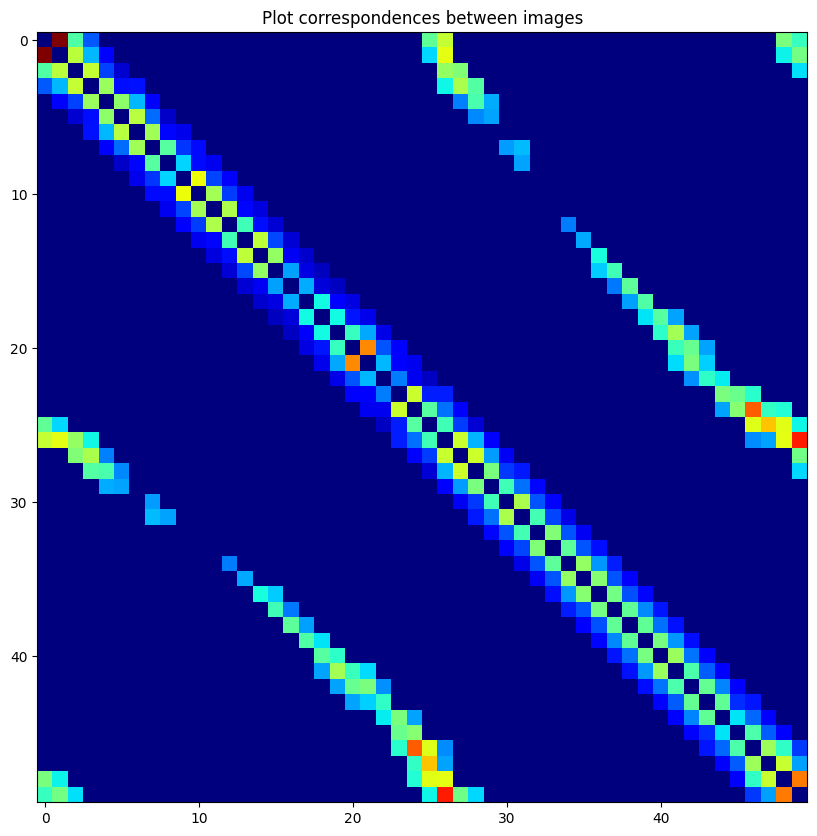

In [75]:
plt.figure(figsize=(10, 10))
plt.title("Plot correspondences between images")
plt.imshow(corr_counts, cmap="jet")

In [47]:
point_manager.get_data()

{'i0': {'p0': [1526.2283935546875, 1053.8184814453125],
  'p1': [629.9837646484375, 713.401123046875],
  'p2': [1418.830810546875, 580.6384887695312],
  'p3': [1286.149658203125, 614.2481689453125],
  'p4': [573.7825927734375, 804.423095703125],
  'p5': [1211.594970703125, 496.6072692871094],
  'p6': [917.033447265625, 632.7322387695312],
  'p7': [610.9383544921875, 847.3502807617188],
  'p8': [1015.9766235351562, 670.7324829101562],
  'p9': [1326.7921142578125, 530.0289916992188],
  'p10': [994.3383178710938, 674.990234375],
  'p11': [953.8675537109375, 543.9817504882812],
  'p12': [645.1380004882812, 709.5859375],
  'p13': [260.79840087890625, 577.3745727539062],
  'p14': [1061.796630859375, 716.5768432617188],
  'p15': [1411.72314453125, 590.4422607421875],
  'p16': [795.8497314453125, 715.8575439453125],
  'p17': [1082.236083984375, 643.5462036132812],
  'p18': [1128.51025390625, 645.8657836914062],
  'p19': [1231.8465576171875, 557.3701171875],
  'p20': [1434.42041015625, 586.1396

In [76]:
# save point correspondences
point_manager.save()

### Convert into bundle adjustment format

In [77]:
class Tools_Preprocess:
    def __init__(self):
        pass

    @staticmethod
    def convert_and_save(PROJECT_DIR, dataset_name, json_data):
        entries_cam_name_cam_idx = []
        entries_cam_pt_pt2d = []
        img_indexes = np.array(sorted([int(k[1:]) for k in list(json_data.keys())])).astype(int)

        for img_idx, img_name in enumerate(img_indexes):
            pts_2d = json_data[f"i{img_name}"]
            entries_cam_name_cam_idx.append([img_idx, img_name])
            for pt_name, pt_pos in pts_2d.items():
                entries_cam_pt_pt2d.append([img_idx, int(pt_name[1:]), pt_pos[0], pt_pos[1]])
        Tools_Preprocess._save_observations(PROJECT_DIR, dataset_name, entries_cam_pt_pt2d)
        Tools_Preprocess._save_camera_id(PROJECT_DIR, dataset_name, entries_cam_name_cam_idx)
            
        # for img_idx, (img_name, pts_2d) in enumerate(json_data.items()):
        #     entries_cam_name_cam_idx.append([img_idx, int(img_name[1:])])
        #     for pt_name, pt_pos in pts_2d.items():
        #         entries_cam_pt_pt2d.append([img_idx, int(pt_name[1:]), pt_pos[0], pt_pos[1]])
        # Tools_Preprocess._save_observations(PROJECT_DIR, dataset_name, entries_cam_pt_pt2d)
        # Tools_Preprocess._save_camera_id(PROJECT_DIR, dataset_name, entries_cam_name_cam_idx)

    @staticmethod
    def _save_observations(PROJECT_DIR, dataset_name, obs_list):
        # save observation txt
        file_obs = os.path.join(PROJECT_DIR, "dataset", dataset_name, "observation.txt")
        with open(file_obs, 'w') as f:
            for i, line in enumerate(obs_list):
                text = ""   
                for j, n in enumerate(line):
                    text += str(n) + ("," if j != (len(line)-1) else "")
                f.write(f"{text}" + ("\n" if i != (len(obs_list) - 1) else ""))
        print("observation file saved!")

    @staticmethod
    def _save_camera_id(PROJECT_DIR, dataset_name, cam_list):
        file_cam_id = os.path.join(PROJECT_DIR, "dataset", dataset_name, "camera_id.txt")
        with open(file_cam_id, 'w') as f:
            for i, line in enumerate(cam_list):
                text = ""   
                for j, n in enumerate(line):
                    text += str(n) + ("," if j != (len(line)-1) else "")
                f.write(f"{text}" + ("\n" if i != (len(cam_list) - 1) else ""))
        print("camera id file saved!")

In [78]:
Tools_Preprocess.convert_and_save(PROJECT_DIR, dataset_name, point_manager.get_data())

observation file saved!
camera id file saved!
